In [1]:
!pip install ipdb

In [2]:
from wsi_registration import TissueDetector, MatcherParameters, WSI_Matcher
import logging
import math

In [3]:
# %pdb on
fixed_wsi = "/Users/jonlinks/Desktop/Testing Restianed Aligner/img/19652.tif"  # file name of your fixed (template) whole slide image
float_wsi = "/Users/jonlinks/Desktop/Testing Restianed Aligner/img/19653_e7.tif"  # file name of your float (moving) whole slide image
# define the tissue detector, so the patches can be sampled
tissue_detector = TissueDetector("LAB_Threshold", threshold=80) # option 1
# tissue_detector = TissueDetector("GNB", threshold=0.5)    # option 2
matcher_parameters = MatcherParameters()  # use the default parameters
matcher = WSI_Matcher(tissue_detector, matcher_parameters)

In [4]:
import openslide
import numpy as np
from skimage.color import rgb2lab

In [5]:
fixed_wsi_obj = openslide.OpenSlide(fixed_wsi)
float_wsi_obj = openslide.OpenSlide(float_wsi)

layer_rescale_factors = fixed_wsi_obj.level_downsamples[1:len(matcher.layer_patch_size) + 1]
thumbnail_fixed, thumbnail_float = matcher.get_thumbnails(fixed_wsi_obj, float_wsi_obj, matcher.rescale_rate)

#thumbnail_fixed = thumbnail_fixed.crop((0, 0, thumbnail_fixed.size[0], thumbnail_fixed.size[1]))
#thumbnail_float = thumbnail_float.crop((thumbnail_float.size[0], 0, thumbnail_float.size[0], thumbnail_float.size[1]))

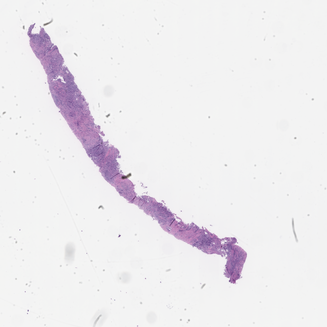

In [6]:
thumbnail_fixed

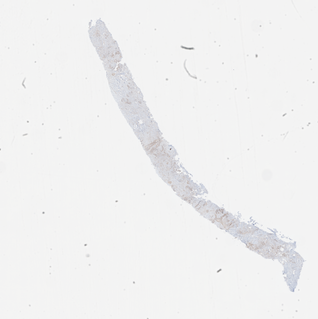

In [7]:
thumbnail_float

In [8]:
import cv2
import matplotlib.pyplot as plt

In [9]:
brisk = cv2.BRISK_create()
gray_fixed = cv2.cvtColor(np.array(thumbnail_fixed),cv2.COLOR_BGR2GRAY)
gray_float = cv2.cvtColor(np.array(thumbnail_float),cv2.COLOR_BGR2GRAY)
(kps_fixed, descs_fixed) = brisk.detectAndCompute(gray_fixed, None)
(kps_float, descs_float) = brisk.detectAndCompute(gray_float, None)
if (descs_fixed is None) or (descs_float is None):
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
if len(kps_fixed) < 3 or len(kps_float) < 3:
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

matches = bf.match(descs_fixed, descs_float)
matches = sorted(matches, key = lambda x:x.distance)
if len(matches) < 3:  # less than 3 points
    reg_status = 0
    init_reg_offset = (0, 0)
    print("not nice")
if len(matches) <= 10:  # get first 10 points
    selected_matches = matches
else:
    selected_matches = matches[0:10]
selected_kps_fixed = []
selected_kps_float = []
for m in selected_matches:
    selected_kps_float.append(kps_float[m.trainIdx])
    selected_kps_fixed.append(kps_fixed[m.queryIdx])

In [10]:
selected_kps_fixed

[< cv2.KeyPoint 0x1ab282dc0>,
 < cv2.KeyPoint 0x1ab283d80>,
 < cv2.KeyPoint 0x1ab282fd0>,
 < cv2.KeyPoint 0x1ab281ce0>,
 < cv2.KeyPoint 0x1ab2a5c50>,
 < cv2.KeyPoint 0x1ab2a7b70>,
 < cv2.KeyPoint 0x1ab2a6040>,
 < cv2.KeyPoint 0x1ab2a5a70>,
 < cv2.KeyPoint 0x1ab2a6ca0>,
 < cv2.KeyPoint 0x1ab2a6b20>]

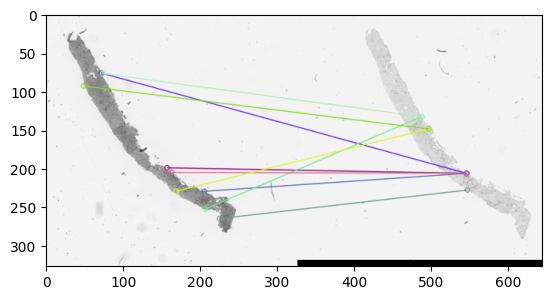

(<matplotlib.image.AxesImage at 0x1ab2dbad0>, None)

In [11]:
img3 = cv2.drawMatches(gray_fixed,kps_fixed,gray_float,kps_float,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [12]:
float_pts = cv2.KeyPoint_convert(selected_kps_float)
fixed_pts = cv2.KeyPoint_convert(selected_kps_fixed)

In [13]:
print(float_pts)
print(fixed_pts)

[[219.35306 206.23378]
 [219.35306 206.23378]
 [219.35306 206.23378]
 [219.35306 206.23378]
 [161.12086 132.77588]
 [219.35306 206.23378]
 [170.06964 148.68367]
 [220.66554 227.92398]
 [161.12086 132.77588]
 [170.06964 148.68367]]
[[157.85477  199.89633 ]
 [205.57741  229.59991 ]
 [157.01363  198.98898 ]
 [ 71.97355   76.29159 ]
 [206.35071  252.60965 ]
 [162.88065  205.08344 ]
 [168.69516  229.44925 ]
 [225.04922  264.99368 ]
 [ 72.890884  76.817764]
 [ 48.33666   92.933556]]


In [14]:
init_offset, status = matcher.get_initial_pos(thumbnail_fixed, thumbnail_float, matcher.rescale_rate)
init_offset, status

thumbnail_down_rate = matcher.rescale_rate

In [22]:
            reprojThresh = 2
            confidence_ratio = 0.5
            (E, status) = cv2.estimateAffinePartial2D(np.float32(fixed_pts), np.float32(float_pts),
                                                      ransacReprojThreshold=reprojThresh, confidence=confidence_ratio)
            if 0 not in status:
                theta = - math.atan2(E[0, 1], E[0, 0]) * 180 / math.pi
                if abs(theta) > 1:
                    reg_status = 0
                    init_reg_offset = (0, 0)
                else:
                    reg_status = 1
                    init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
            else:
                counts = np.count_nonzero(status ==
                                          0)
                if counts > 5:  # if over 50% fails
                    reg_status = 0
                    init_reg_offset = (0, 0)
                else:
                    init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
                    reg_status = 1
            return init_reg_offset, reg_status

SyntaxError: 'return' outside function (3122527820.py, line 22)

In [16]:
brisk = cv2.BRISK_create()
(kps_fixed, descs_fixed) = brisk.detectAndCompute(np.array(thumbnail_fixed), None)
(kps_float, descs_float) = brisk.detectAndCompute(np.array(thumbnail_float), None)
if (descs_fixed is None) or (descs_float is None):
    reg_status = 0
    init_reg_offset = (0, 0)
if len(kps_fixed) < 3 or len(kps_float) < 3:
    reg_status = 0
    init_reg_offset = (0, 0)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
try:
    matches = bf.match(descs_fixed, descs_float)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < 3:  # less than 3 points
        reg_status = 0
        init_reg_offset = (0, 0)
    if len(matches) <= 10:  # get first 10 points
        selected_matches = matches
    else:
        selected_matches = matches[0:10]
    selected_kps_fixed = []
    selected_kps_float = []
    for m in selected_matches:
        selected_kps_float.append(kps_float[m.trainIdx].pt)
        selected_kps_fixed.append(kps_fixed[m.queryIdx].pt)
    reprojThresh = 2
    confidence_ratio = 0.5
    (E, status) = cv2.estimateAffinePartial2D(np.float32(fixed_pts), np.float32(float_pts),
                                                ransacReprojThreshold=reprojThresh, confidence=confidence_ratio)
    if 0 not in status:
        theta = - math.atan2(E[0, 1], E[0, 0]) * 180 / math.pi
        print(theta)
        if abs(theta) > 1:
            reg_status = 0
            init_reg_offset = (0, 0)
        else:
            reg_status = 1
            init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
    else:
        counts = np.count_nonzero(status == 0)
        if counts > 5:  # if over 50% fails
            reg_status = 0
            init_reg_offset = (0, 0)
        else:
            init_reg_offset = (E[0, 2] * thumbnail_down_rate, E[1, 2] * thumbnail_down_rate)
            reg_status = 1
except:
    reg_status = 0
    init_reg_offset = (0, 0)

In [17]:
E

array([[  0.        ,  -0.        , 219.35305786],
       [  0.        ,   0.        , 206.23377991]])

In [18]:
init_reg_offset, status

((21935.30578613281, 20623.377990722653),
 array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0]], dtype=uint8))

In [ ]:
matcher.layer_patch_max_num

In [33]:
fixed_foreground_mask = tissue_detector.predict(thumbnail_fixed, open_operation=True)
indices = {}
for i in range(len(matcher.layer_patch_max_num)):  # layers
    fixed_indices, float_indices = matcher.get_sample_locations(fixed_foreground_mask, init_reg_offset, matcher.layer_patch_max_num, thumb_rescale=matcher.rescale_rate, from_fixed_thumb=True)
    indices["level_"+str(i+1)] = (fixed_indices, float_indices)
indicies_dict = indices

In [19]:
indices_dict = matcher.get_all_sample_indices(thumbnail_fixed, init_reg_offset, matcher.rescale_rate, matcher.layer_patch_max_num)
indices_dict

{'level_1': ([array([16500, 15400, 18300, 11000, 23900, 20800, 15600, 14700, 13100,
           3200,  7800,  9400, 10100, 20300, 14800, 23100, 19700, 18400,
           8600,  7300]),
   array([11400, 10300, 11700,  6600, 18400, 16000,  9700, 10800,  8400,
           4400,  6600,  5300,  6300, 15200, 10800, 19300, 14100, 12400,
           5900,  5200])],
  [array([37123, 36023, 38923, 31623, 44523, 41423, 36223, 35323, 33723,
          23823, 28423, 30023, 30723, 40923, 35423, 43723, 40323, 39023,
          29223, 27923]),
   array([33335, 32235, 33635, 28535, 40335, 37935, 31635, 32735, 30335,
          26335, 28535, 27235, 28235, 37135, 32735, 41235, 36035, 34335,
          27835, 27135])]),
 'level_2': ([array([ 4400, 22400, 22500, 23100,  5500, 16000, 22200, 15100,  5800,
          11300, 10400, 12500,  3600, 15600, 12700, 27600, 23000, 26000,
          16600, 24700, 16700, 15900, 11600, 14100, 24300, 17600, 23300,
          26300,  4400, 17200, 26400, 10100, 24600, 21300,  8300, 11

In [70]:
offset_dict = matcher.match_sample_patches(fixed_wsi_obj, float_wsi_obj, indices_dict, matcher.layer_patch_num, matcher.layer_patch_size, layer_rescale_factors)

[2000, 800, 500]


In [71]:
dims = float_wsi_obj.level_dimensions   

In [80]:
fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[0],fixed_loc_x[0]), 1, dims[0])

In [83]:
fixed_patch.show()

In [84]:
for l in range(len(matcher.layer_patch_size)):
    [fixed_loc_x, fixed_loc_y], [float_loc_x, float_loc_y]=indices_dict.get("level_" + str(l + 1))
    layer_match_offset = []
    layer_matched_patch_cnt = 0
    for p in range(len(fixed_loc_x)):
        print(l)
        fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[p], fixed_loc_x[p]), l + 1, dims[l]).convert("RGB")
        float_patch = float_wsi_obj.read_region((float_loc_y[p], float_loc_x[p]), l + 1, dims[l]).convert("RGB")
        Content_rich_fixed = matcher.filter_by_content_area(np.array(fixed_patch), area_threshold=0.5)
        Content_rich_float = matcher.filter_by_content_area(np.array(float_patch), area_threshold=0.5)

0


In [58]:
Content_rich_float

False

In [50]:
offset_dict

{'level_1': [], 'level_2': [], 'level_3': []}

In [24]:
patches_match_offset_dic = {}
for l in range(len(matcher.layer_patch_size)):
    [fixed_loc_x, fixed_loc_y], [float_loc_x, float_loc_y] = indices_dict.get("level_" + str(l + 1))
    layer_match_offset = []
    layer_matched_patch_cnt = 0
    for p in range(len(fixed_loc_x)):
        fixed_patch = fixed_wsi_obj.read_region((fixed_loc_y[p], fixed_loc_x[p]), l + 1, (matcher.layer_patch_size[l]//2, matcher.layer_patch_size[l]//2)).convert("RGB")
        float_patch = float_wsi_obj.read_region((float_loc_y[p]-1000, float_loc_x[p]-1000), l + 1, (matcher.layer_patch_size[l], matcher.layer_patch_size[l])).convert("RGB")
        Content_rich_fixed = matcher.filter_by_content_area(np.array(fixed_patch), area_threshold=0.5)
        Content_rich_float = matcher.filter_by_content_area(np.array(float_patch), area_threshold=0.5)
        break
    break

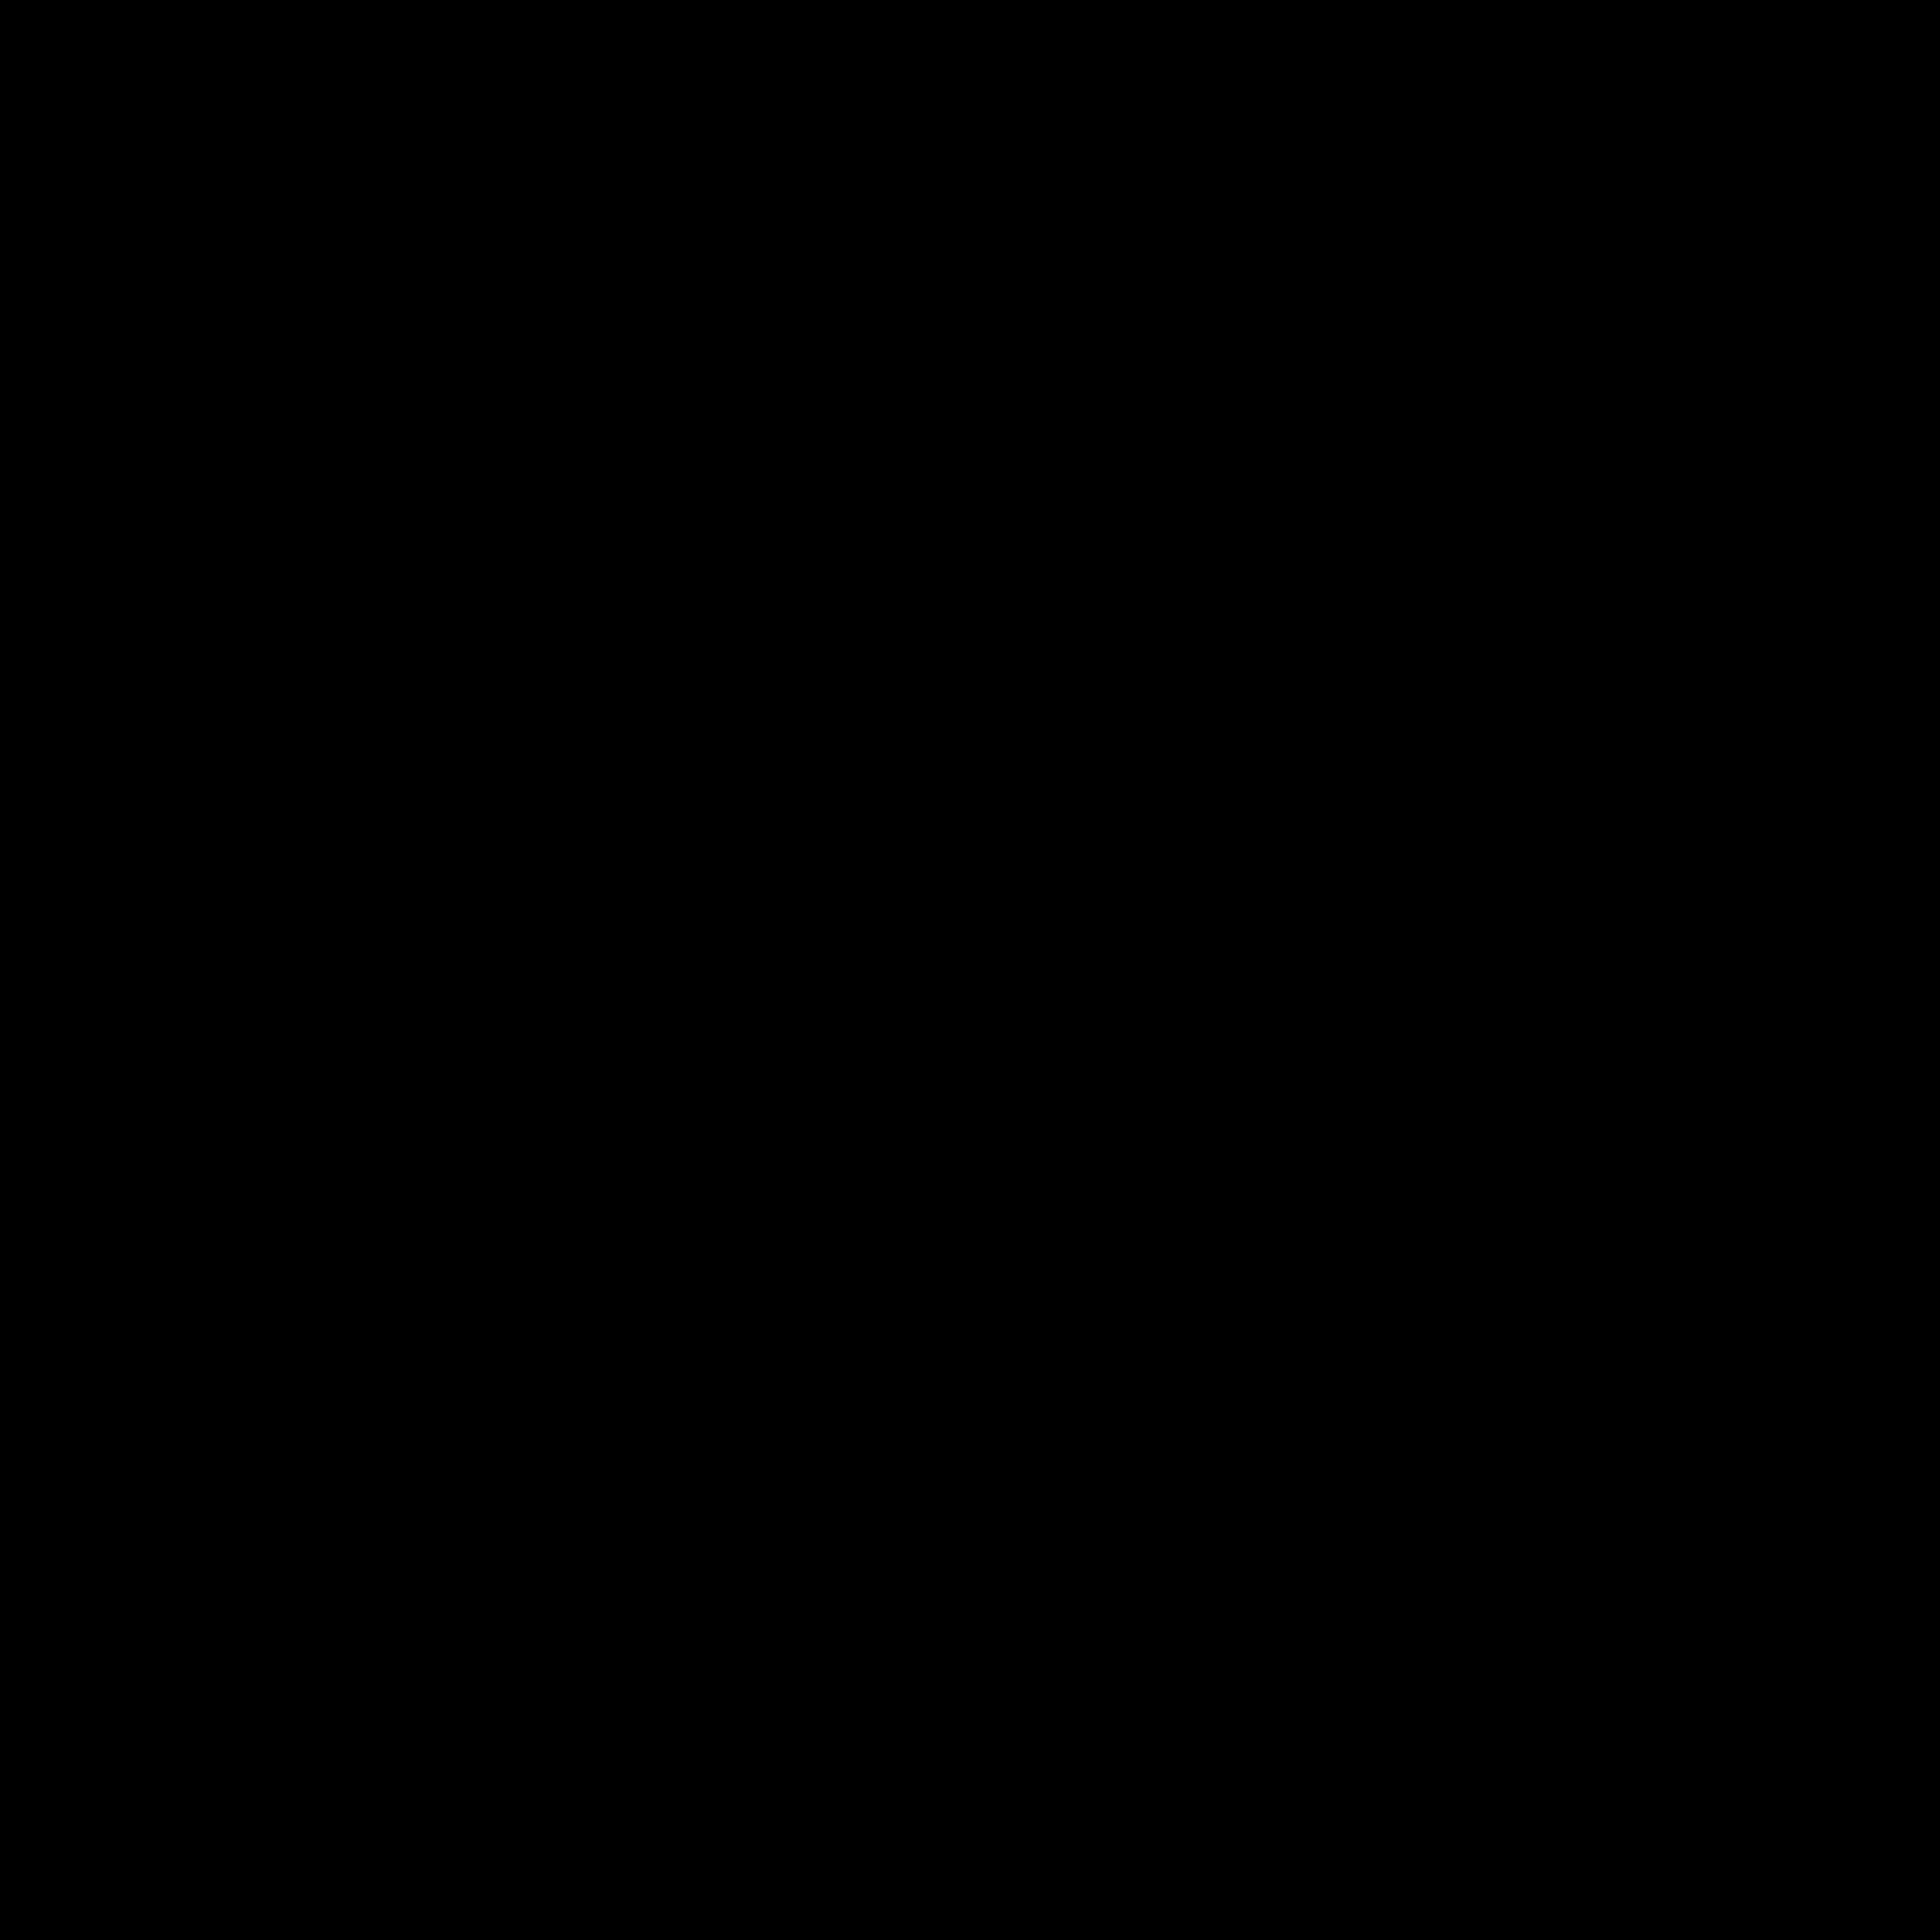

In [40]:
float_patch

In [30]:
float_patch = float_wsi_obj.read_region((fixed_loc_y[p]+10000, fixed_loc_x[p]-20000), l + 1, (matcher.layer_patch_size[l]*2, matcher.layer_patch_size[l]*2)).convert("RGB")

In [28]:
import matplotlib.pyplot as plt

In [32]:
rgb_image_array = np.array(float_patch)
area_threshold = 0.5
brightness = 85

In [33]:
rgb_image_array

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [34]:
fixed_loc_y[p]

6400

In [35]:
thumbnail_float.size[0]//2

159

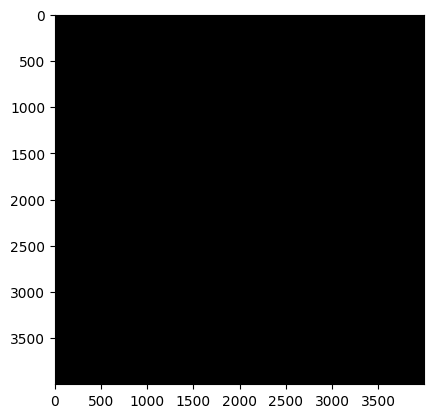

In [37]:
plt.imshow(rgb_image_array)

In [62]:
np.any(rgb_image_array == [0, 0, 0], axis=-1).sum()

16000000

In [63]:
rgb_image_array[np.any(rgb_image_array == [0, 0, 0], axis=-1)] = [255, 255, 255]

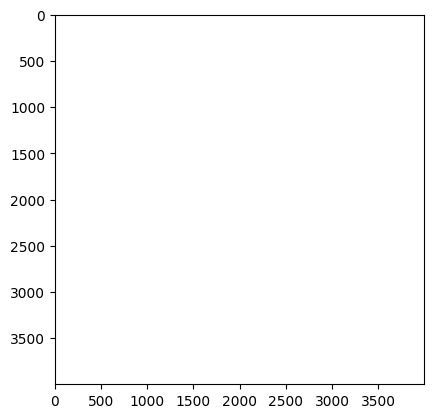

In [64]:
plt.imshow(rgb_image_array)

In [26]:
lab_img = rgb2lab(rgb_image_array)
l_img = lab_img[:, :, 0]

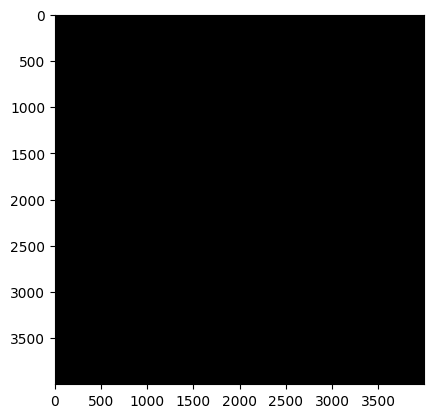

In [27]:
plt.imshow(l_img, cmap="gray")

In [28]:
binary_img = l_img < brightness

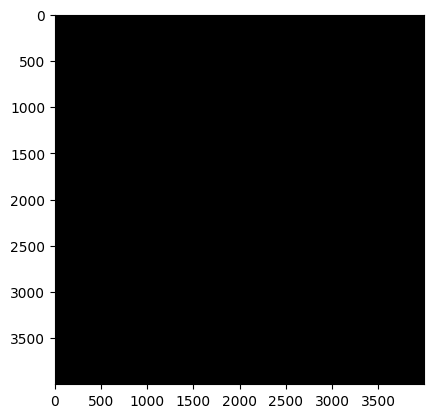

In [29]:
plt.imshow(binary_img, cmap="gray")

In [30]:
tissue_size = np.where(binary_img > 0)[0].size
tissue_ratio = tissue_size*3/rgb_image_array.size  # 3 channels
tissue_ratio > area_threshold

False

In [31]:
%matplotlib inline

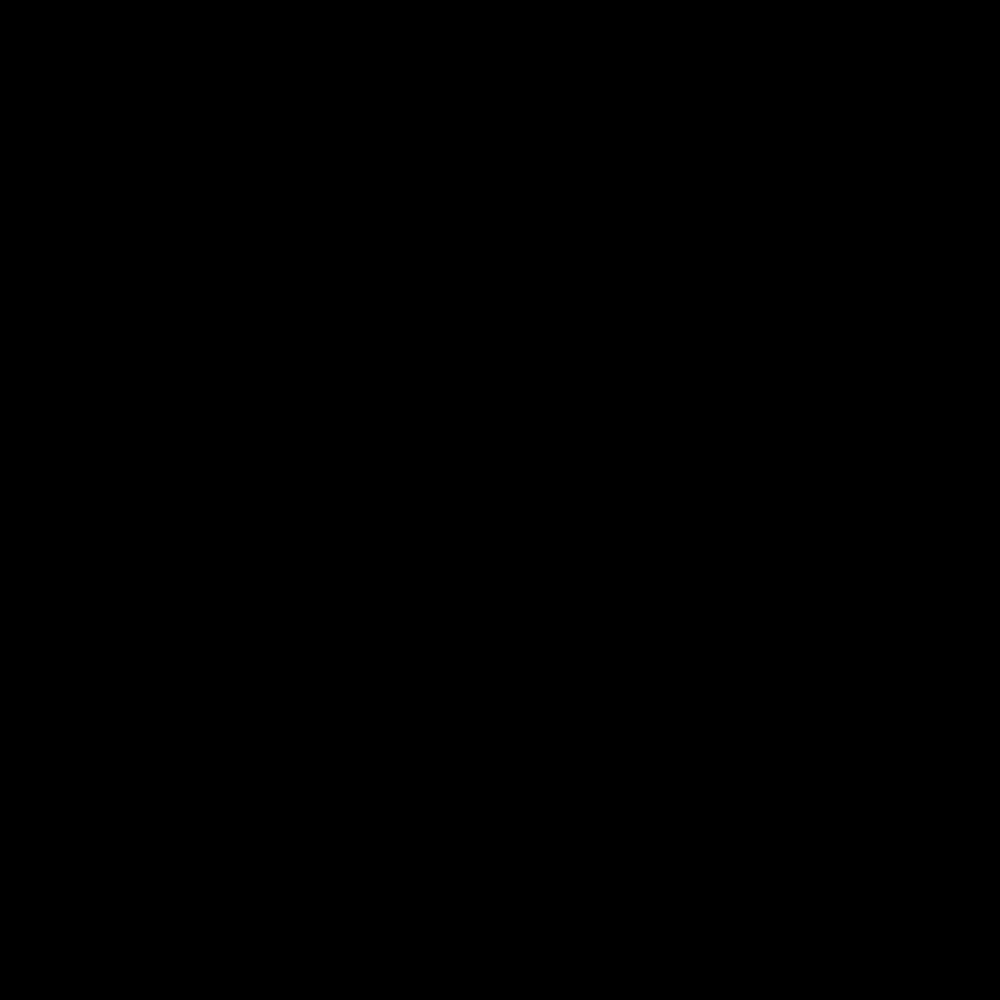

In [32]:
fixed_patch

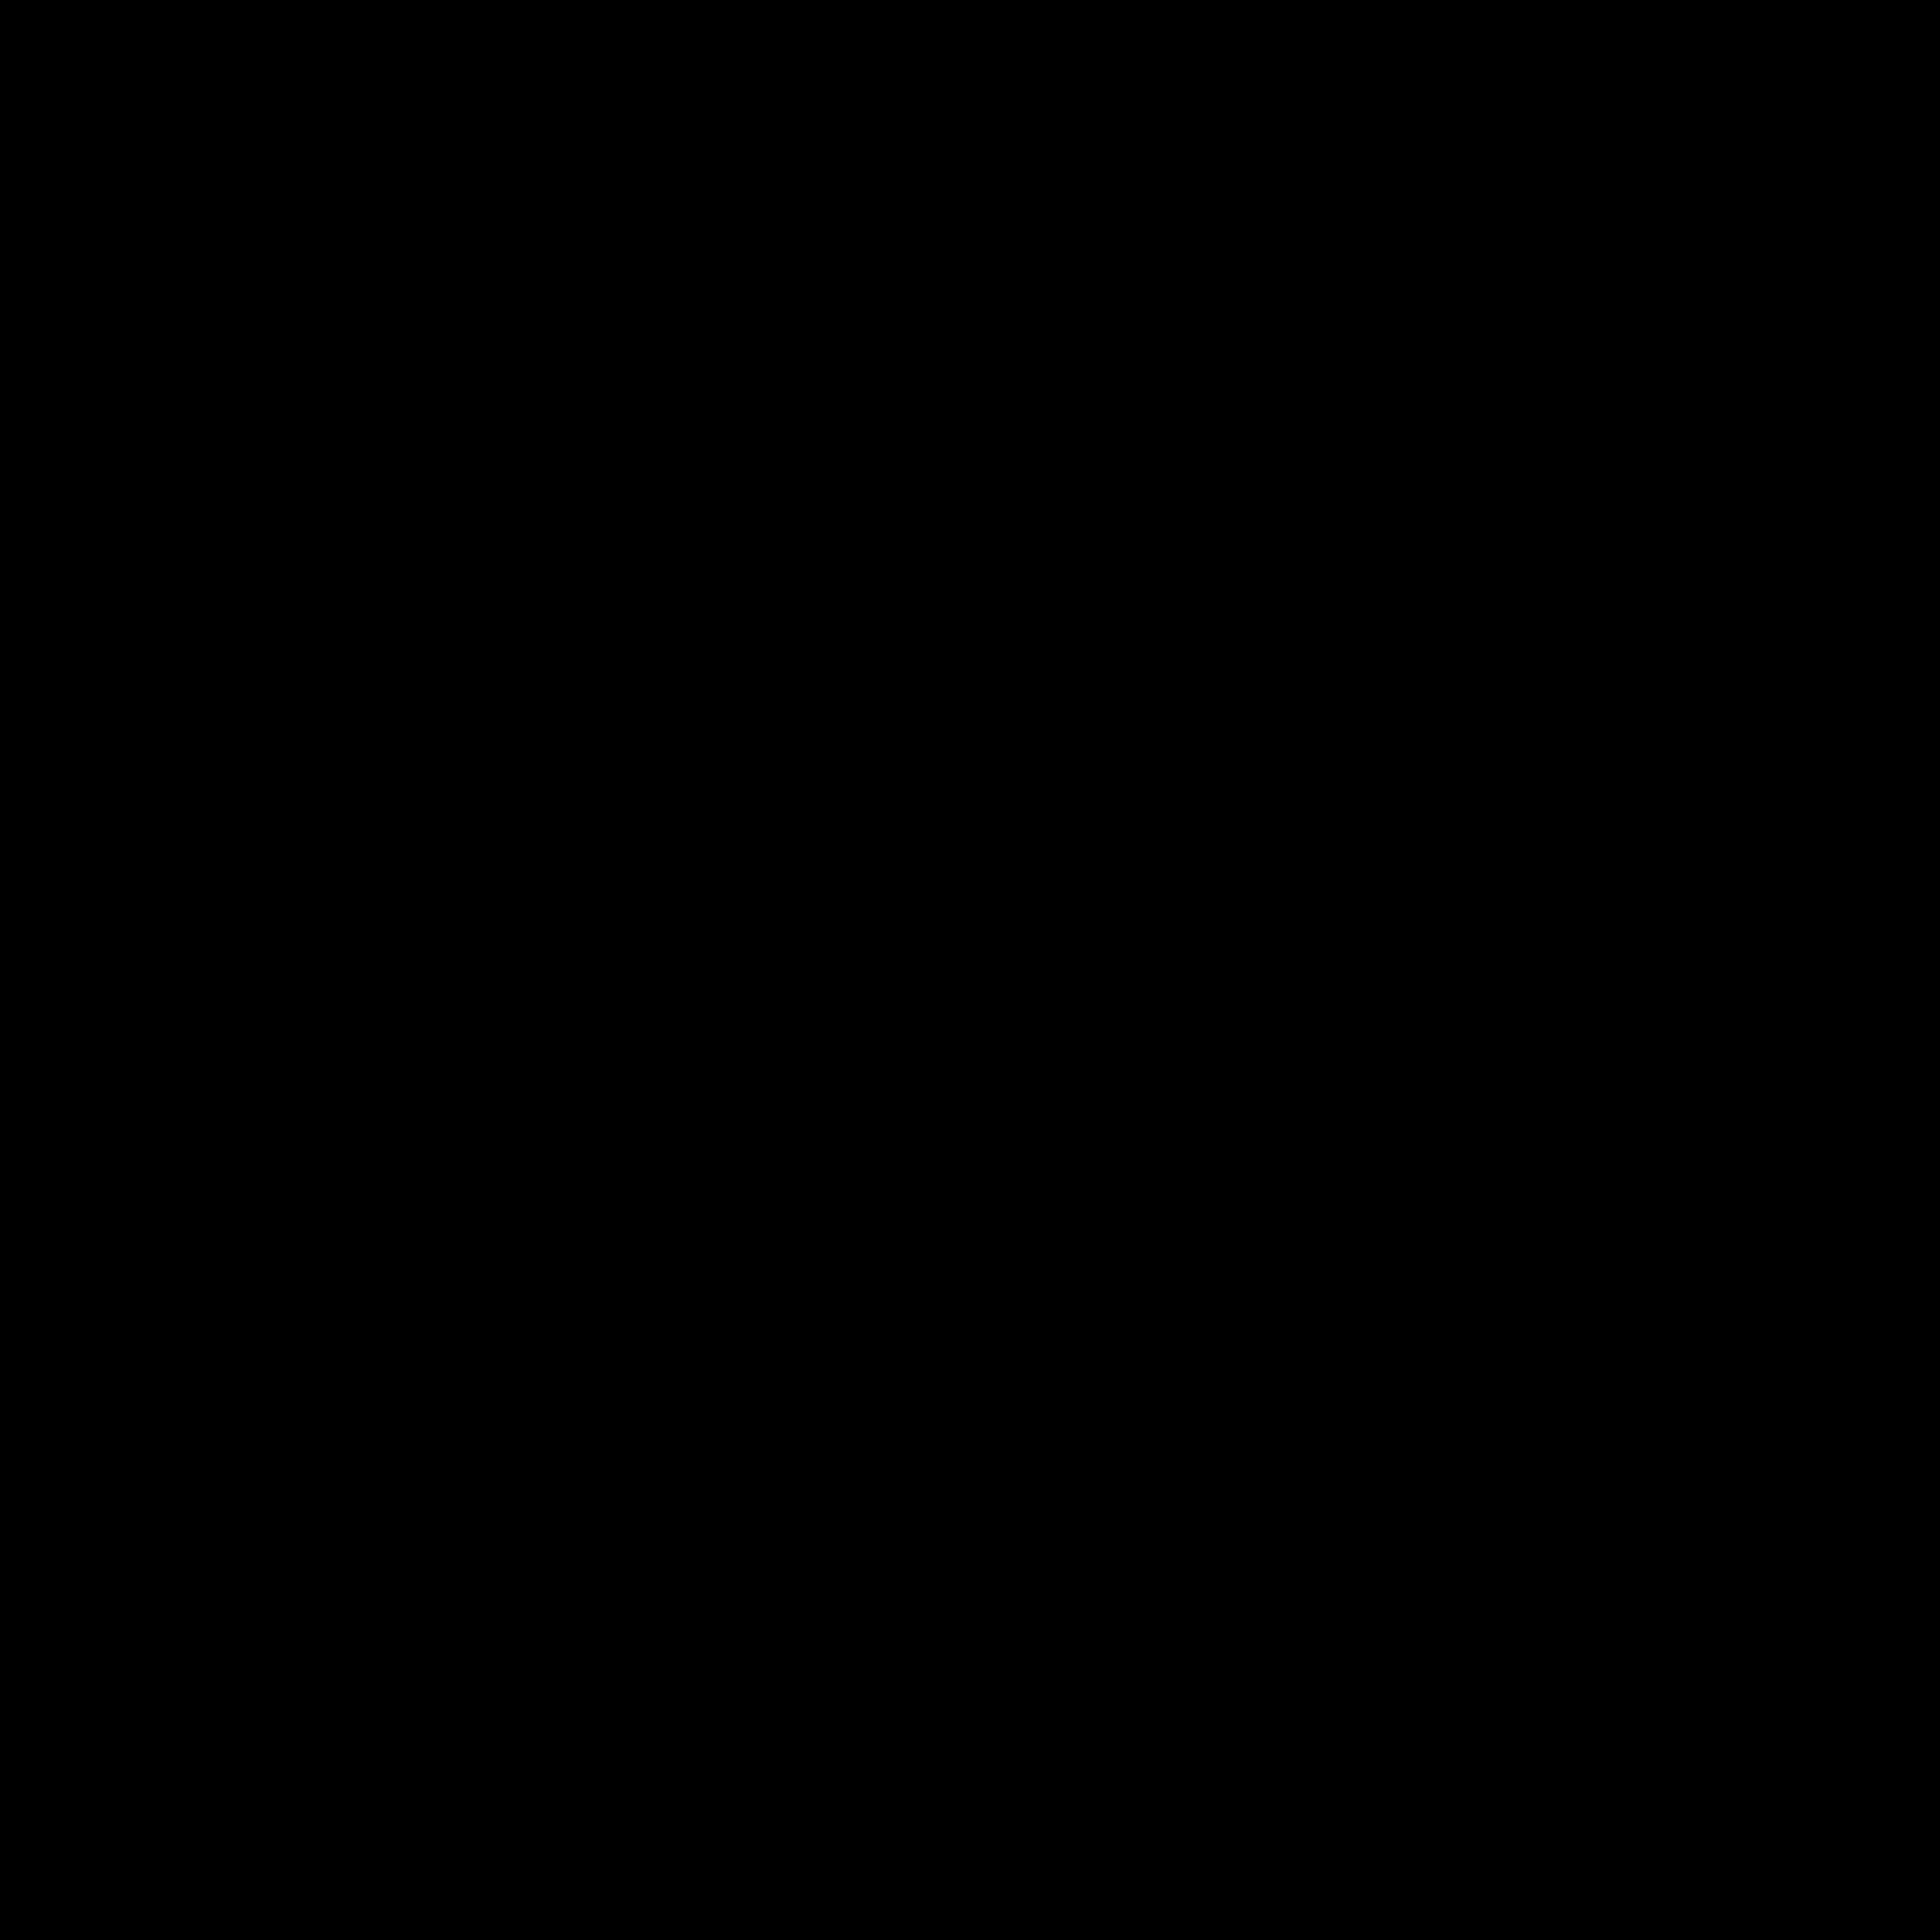

In [33]:
float_patch

In [37]:
offset = matcher.match(fixed_wsi, float_wsi)
logging.debug("Shifting offset: %d %d" % offset)
print("Shifting offset: %d %d" % offset)

> /Users/jonlinks/Desktop/Testing Restianed Aligner/src/wsi_registration_new.py(314)match()
    313         import ipdb; ipdb.set_trace()
--> 314         rescale_rate = self.rescale_rate
    315         layer_patch_num = self.layer_patch_num

ipdb> 
ipdb> 
ipdb> 
ipdb> 
ipdb> 
ipdb> 
ipdb> 
ipdb> 
ipdb> what?
Object `what` not found.
ipdb> fixed_wsi
*** NameError: name 'fixed_wsi' is not defined
ipdb> float_wsi
*** NameError: name 'float_wsi' is not defined
ipdb> float_patch
*** NameError: name 'float_patch' is not defined
ipdb> 
*** NameError: name 'float_patch' is not defined
ipdb> ç
*** NameError: name 'ç' is not defined
ipdb> 
*** NameError: name 'ç' is not defined
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


Exception: Can't align thumbnail

In [35]:
print("Shifting offset: %d %d" % offset)

NameError: name 'offset' is not defined